### Descriptive and comparative analysis of IgA measures

This notebook explores different strategies to compare IgA measures using different categorical values for Attachment and Gender.

Specifically, this notebook implements:

- Reading and cleaning input data
- Remove non-relevant columns
- Plot distributions of IgA by Attachment and Gender using boxplots and violin plots
- Statistical comparison for IgA measures by U-test and kruskal with Dunn test
- Estimating Cliffs for detecting differences between distributions
- Estimating Rank biserial
- Exploring clustering strategies for pattern generation

- Handling modules

In [54]:
import warnings
warnings.filterwarnings("ignore")

- Loading modules

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
from scipy.stats import kruskal
from typing import Tuple
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler

- Auxiliar functions

In [56]:
def classify_iga_level(avg):
    if avg > 100:
        return "High sIgA"
    elif avg < 30:
        return "Low sIgA"
    else:
        return "Moderate sIgA"

In [57]:
def rank_biserial_correlation(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute rank-biserial correlation from two independent samples.
    """
    from scipy.stats import mannwhitneyu

    nx = len(x)
    ny = len(y)

    U, _ = mannwhitneyu(x, y, alternative='two-sided')
    rbc = 1 - (2 * U) / (nx * ny)

    abs_rbc = abs(rbc)
    if abs_rbc < 0.1:
        interpretation = "Negligible"
    elif abs_rbc < 0.3:
        interpretation = "Small"
    elif abs_rbc < 0.5:
        interpretation = "Medium"
    else:
        interpretation = "Large"

    return rbc, interpretation

In [58]:
def cliffs_delta(x: pd.Series, y: pd.Series) -> Tuple[float, str]:
    """
    Compute Cliff's Delta and return interpretation.
    """
    nx = len(x)
    ny = len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (greater - less) / (nx * ny)

    abs_delta = abs(delta)
    if abs_delta < 0.147:
        interpretation = "Negligible"
    elif abs_delta < 0.33:
        interpretation = "Small"
    elif abs_delta < 0.474:
        interpretation = "Medium"
    else:
        interpretation = "Large"
    return delta, interpretation

-Loading data

In [59]:
df_data = pd.read_csv("../processed_data/1_processed_data_IgA.csv")
df_data.head(5)

,ID,Gender,IgA_Average_Morning,IgA_Average_Afternoon,Average_Difference,Attachment
0,1,Male,21.765240,28.368055,6.602815,Insecure
1,4,Male,28.473065,50.881961,22.408896,Secure
2,5,Female,161.424693,46.867951,-114.556742,Secure
3,7,Female,24.173487,35.942378,14.343241,Insecure
4,11,Male,78.013279,382.715268,345.590046,Unknown


In [60]:
df_data.columns

Index(['ID', 'Gender', 'IgA_Average_Morning', 'IgA_Average_Afternoon',
       'Average_Difference', 'Attachment'],
      dtype='object')

In [61]:
df_data.columns = ['ID', 'Gender', 'sIgA Average Morning', 'sIgA Average Afternoon',
       'sIgA Average Difference', 'Attachment']

In [62]:
df_data["Attachment"].value_counts()

Attachment
Secure      18
Insecure     9
Unknown      8
Name: count, dtype: int64

- Prepare data for plots

In [63]:
df_data_plot = df_data[df_data["Attachment"] != "Unknown"]
df_data_plot.head()

,ID,Gender,sIgA Average Morning,sIgA Average Afternoon,sIgA Average Difference,Attachment
0,1,Male,21.765240,28.368055,6.602815,Insecure
1,4,Male,28.473065,50.881961,22.408896,Secure
2,5,Female,161.424693,46.867951,-114.556742,Secure
3,7,Female,24.173487,35.942378,14.343241,Insecure
5,12,Female,29.554870,45.078186,15.523316,Secure


- Data visualization

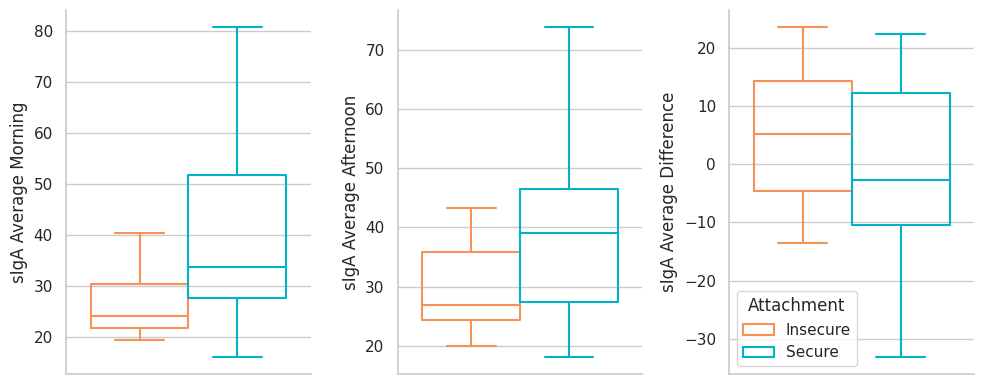

In [64]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Morning", 
    hue="Attachment", 
    ax=axes[0], 
    fill=False,
    palette=palette,
    showfliers=False, 
    legend=False)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Afternoon", 
    hue="Attachment", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    showfliers=False,
    legend=False)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Difference", 
    hue="Attachment", 
    ax=axes[2], 
    palette=palette,
    showfliers=False,
    fill=False)

sns.despine()
plt.tight_layout()

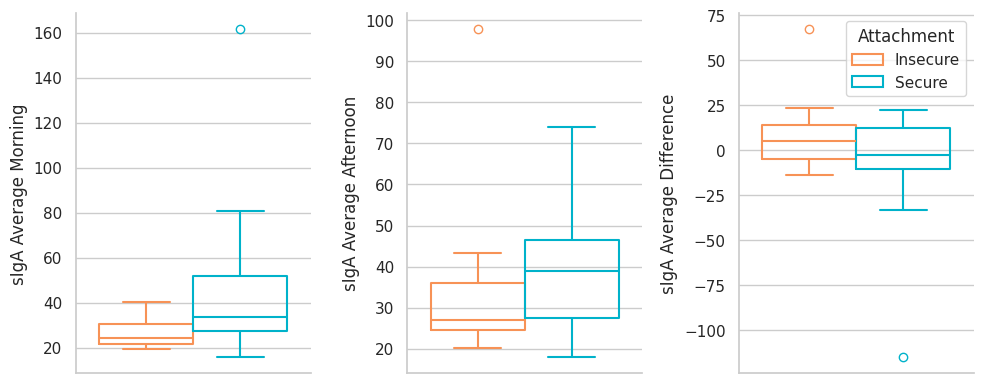

In [65]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Morning", 
    hue="Attachment", 
    ax=axes[0], 
    fill=False,
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Afternoon", 
    hue="Attachment", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Difference", 
    hue="Attachment", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

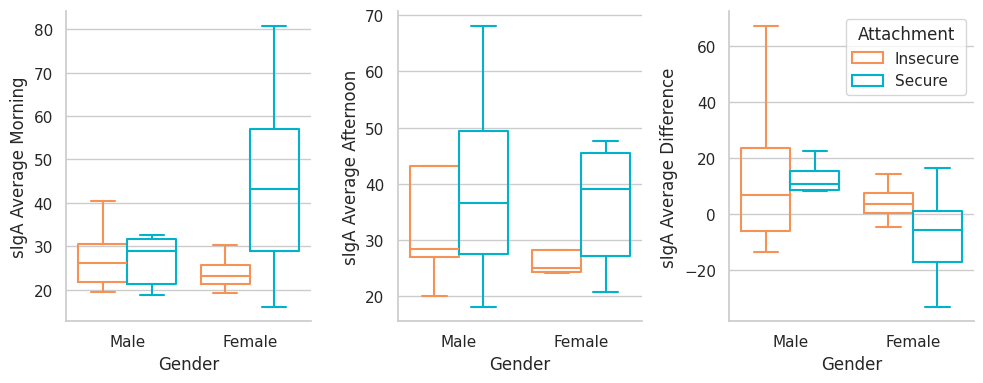

In [66]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Morning", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[0], 
    fill=False,
    showfliers=False,
    palette=palette, 
    legend=False)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Afternoon", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[1], 
    fill=False, 
    showfliers=False,
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Difference", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[2], 
    palette=palette,
    showfliers=False,
    fill=False)

sns.despine()
plt.tight_layout()

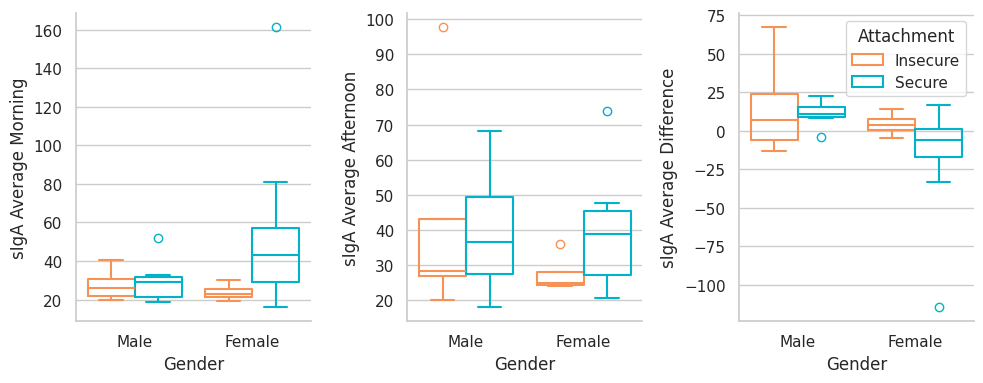

In [67]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Morning", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Afternoon", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Difference", 
    hue="Attachment", 
    x="Gender", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

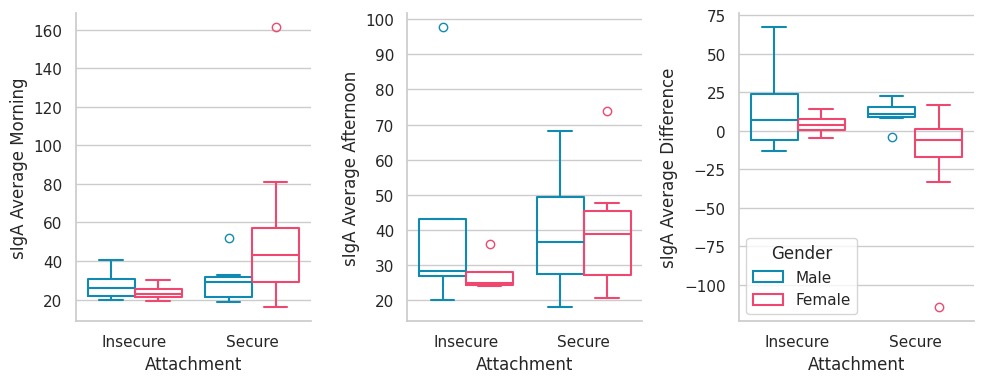

In [68]:
sns.set(style="whitegrid", font_scale=1)

palette = {"Male": "#118AB2", "Female": "#EF476F"}

f, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Morning", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[0], 
    fill=False,
    palette=palette, 
    legend=False)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Afternoon", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=df_data_plot, 
    y="sIgA Average Difference", 
    x="Attachment", 
    hue="Gender", 
    ax=axes[2], 
    palette=palette,
    fill=False)

sns.despine()
plt.tight_layout()

- U-test and Kruskal comparison

In [69]:
iga_vars = ["sIgA Average Morning", "sIgA Average Afternoon", "sIgA Average Difference"]

gender_results = []
for var in iga_vars:
    male_vals = df_data_plot[df_data_plot["Gender"] == "Male"][var]
    female_vals = df_data_plot[df_data_plot["Gender"] == "Female"][var]
    stat, p = mannwhitneyu(male_vals, female_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    gender_results.append(statistic_result)

gender_results = pd.DataFrame(gender_results)
gender_results["reject"] = gender_results["p-value"]<=0.05
gender_results

,variable,U statistic,p-value,reject
0,sIgA Average Morning,60.0,0.174773,False
1,sIgA Average Afternoon,96.0,0.711310,False
2,sIgA Average Difference,128.0,0.051274,False


In [70]:
attachment_results = []
for var in iga_vars:
    secure_vals = df_data_plot[df_data_plot["Attachment"] == "Secure"][var]
    insecure_vals = df_data_plot[df_data_plot["Attachment"] == "Insecure"][var]
    stat, p = mannwhitneyu(secure_vals, insecure_vals, alternative='two-sided')
    statistic_result = {"variable": var, "U statistic": stat, "p-value": p}
    attachment_results.append(statistic_result)

attachment_results = pd.DataFrame(attachment_results)
attachment_results["reject"] = attachment_results["p-value"]<=0.05
attachment_results

,variable,U statistic,p-value,reject
0,sIgA Average Morning,116.0,0.075982,False
1,sIgA Average Afternoon,103.0,0.268795,False
2,sIgA Average Difference,66.0,0.455789,False


In [71]:
df_data_plot["Group"] = df_data_plot["Attachment"] + " - " + df_data_plot["Gender"]

kruskal_results = {}
for var in iga_vars:
    data = [group[var].values for name, group in df_data_plot.groupby("Group")]
    stat, p = kruskal(*data)
    kruskal_results[var] = {"H statistic": stat, "p-value": p}
kruskal_df = pd.DataFrame(kruskal_results).T

print("=== Kruskal–Wallis Results ===")
print(kruskal_df)

# Post-hoc Dunn test with Holm correction
print("\n=== Dunn's Test (Holm-corrected p-values) ===")
for var in iga_vars:
    print(f"\n--- {var} ---")
    posthoc = sp.posthoc_dunn(
        df_data_plot,
        val_col=var,
        group_col="Group",
        p_adjust='holm'
    )
    print(posthoc)

=== Kruskal–Wallis Results ===
                         H statistic   p-value
sIgA Average Morning        6.066667  0.108411
sIgA Average Afternoon      2.191005  0.533722
sIgA Average Difference     5.012698  0.170870

=== Dunn's Test (Holm-corrected p-values) ===

--- sIgA Average Morning ---
                   Insecure - Female  Insecure - Male  Secure - Female  \
Insecure - Female           1.000000         1.000000         0.250081   
Insecure - Male             1.000000         1.000000         0.516332   
Secure - Female             0.250081         0.516332         1.000000   
Secure - Male               1.000000         1.000000         0.516332   

                   Secure - Male  
Insecure - Female       1.000000  
Insecure - Male         1.000000  
Secure - Female         0.516332  
Secure - Male           1.000000  

--- sIgA Average Afternoon ---
                   Insecure - Female  Insecure - Male  Secure - Female  \
Insecure - Female                1.0              1.

- Cliffs estimation

In [72]:
gender_cliffs = []
for var in iga_vars:
    male = df_data_plot[df_data_plot["Gender"] == "Male"][var]
    female = df_data_plot[df_data_plot["Gender"] == "Female"][var]
    delta, interp = cliffs_delta(male, female)
    gender_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

gender_cliffs = pd.DataFrame(gender_cliffs)
gender_cliffs

,variable,Cliff's Delta,Interpretation
0,sIgA Average Morning,-0.318182,Small
1,sIgA Average Afternoon,0.090909,Negligible
2,sIgA Average Difference,0.454545,Medium


In [73]:
attachment_cliffs = []
for var in iga_vars:
    secure = df_data_plot[df_data_plot["Attachment"] == "Secure"][var]
    insecure = df_data_plot[df_data_plot["Attachment"] == "Insecure"][var]
    delta, interp = cliffs_delta(insecure, secure)
    attachment_cliffs.append({"variable": var, "Cliff's Delta": delta, "Interpretation": interp})

attachment_cliffs = pd.DataFrame(attachment_cliffs)
attachment_cliffs

,variable,Cliff's Delta,Interpretation
0,sIgA Average Morning,-0.432099,Medium
1,sIgA Average Afternoon,-0.271605,Small
2,sIgA Average Difference,0.185185,Small


In [74]:
combined_cliffs = {}
grouped = df_data_plot.groupby(["Attachment", "Gender"])
groups = list(grouped.groups.keys())

if len(groups) >= 2:
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            label = f"{g1} vs {g2}"
            results = {}
            for var in iga_vars:
                data1 = grouped.get_group(g1)[var]
                data2 = grouped.get_group(g2)[var]
                if len(data1) > 0 and len(data2) > 0:
                    delta, interp = cliffs_delta(data1, data2)
                    results[var] = {"Cliff's Delta": delta, "Interpretation": interp}
            combined_cliffs[label] = results

combined_cliffs_df = pd.concat({k: pd.DataFrame(v).T for k, v in combined_cliffs.items()}, names=["Group Comparison", "Variable"])
combined_cliffs_df

Cliff's Delta  \
Group Comparison                               Variable                                
('Insecure', 'Female') vs ('Insecure', 'Male') sIgA Average Morning             -0.3   
                                               sIgA Average Afternoon           -0.4   
                                               sIgA Average Difference          -0.1   
('Insecure', 'Female') vs ('Secure', 'Female') sIgA Average Morning        -0.666667   
                                               sIgA Average Afternoon      -0.458333   
                                               sIgA Average Difference      0.416667   
('Insecure', 'Female') vs ('Secure', 'Male')   sIgA Average Morning        -0.166667   
                                               sIgA Average Afternoon           -0.5   
                                               sIgA Average Difference          -0.5   
('Insecure', 'Male') vs ('Secure', 'Female')   sIgA Average Morning        -0.566667   
                                               sIgA Average Afternoon           -0.1   
                                               sIgA Average Difference      0.433333   
('Insecure', 'Male') vs ('Secure', 'Male')     sIgA Average Morning              0.0   
                                               sIgA Average Afternoon      -0.133333   
                                               sIgA Average Difference     -0.133333   
('Secure', 'Female') vs ('Secure', 'Male')     sIgA Average Morning         0.444444   
                                               sIgA Average Afternoon      -0.027778   
                                               sIgA Average Difference     -0.555556   

                                                                       Interpretation  
Group Comparison                               Variable                                
('Insecure', 'Female') vs ('Insecure', 'Male') sIgA Average Morning             Small  
                                               sIgA Average Afternoon          Medium  
                                               sIgA Average Difference     Negligible  
('Insecure', 'Female') vs ('Secure', 'Female') sIgA Average Morning             Large  
                                               sIgA Average Afternoon          Medium  
                                               sIgA Average Difference         Medium  
('Insecure', 'Female') vs ('Secure', 'Male')   sIgA Average Morning             Small  
                                               sIgA Average Afternoon           Large  
                                               sIgA Average Difference          Large  
('Insecure', 'Male') vs ('Secure', 'Female')   sIgA Average Morning             Large  
                                               sIgA Average Afternoon      Negligible  
                                               sIgA Average Difference         Medium  
('Insecure', 'Male') vs ('Secure', 'Male')     sIgA Average Morning        Negligible  
                                               sIgA Average Afternoon      Negligible  
                                               sIgA Average Difference     Negligible  
('Secure', 'Female') vs ('Secure', 'Male')     sIgA Average Morning            Medium  
                                               sIgA Average Afternoon      Negligible  
                                               sIgA Average Difference          Large

- RBC estimation 

In [75]:
rbc_gender = []
for var in iga_vars:
    male = df_data_plot[df_data_plot["Gender"] == "Male"][var]
    female = df_data_plot[df_data_plot["Gender"] == "Female"][var]
    rbc, interp = rank_biserial_correlation(male, female)
    rbc_gender.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_gender = pd.DataFrame(rbc_gender)
rbc_gender

,variable,Rank-Biserial Corr,Interpretation
0,sIgA Average Morning,0.318182,Medium
1,sIgA Average Afternoon,-0.090909,Negligible
2,sIgA Average Difference,-0.454545,Medium


In [76]:
rbc_attachment = []
for var in iga_vars:
    secure = df_data_plot[df_data_plot["Attachment"] == "Secure"][var]
    insecure = df_data_plot[df_data_plot["Attachment"] == "Insecure"][var]
    rbc, interp = rank_biserial_correlation(secure, insecure)
    rbc_attachment.append({"variable": var, "Rank-Biserial Corr": rbc, "Interpretation": interp})
rbc_attachment = pd.DataFrame(rbc_attachment)
rbc_attachment

,variable,Rank-Biserial Corr,Interpretation
0,sIgA Average Morning,-0.432099,Medium
1,sIgA Average Afternoon,-0.271605,Small
2,sIgA Average Difference,0.185185,Small


- Merge all comparisons

In [77]:
rbc_combined = {}
grouped = df_data_plot.groupby(["Attachment", "Gender"])
groups = list(grouped.groups.keys())

if len(groups) >= 2:
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            label = f"{g1} vs {g2}"
            results = {}
            for var in iga_vars:
                data1 = grouped.get_group(g1)[var]
                data2 = grouped.get_group(g2)[var]
                if len(data1) > 0 and len(data2) > 0:
                    rbc, interp = rank_biserial_correlation(data1, data2)
                    results[var] = {"Rank-Biserial Corr": rbc, "Interpretation": interp}
            rbc_combined[label] = results

rbc_combined_df = pd.concat({k: pd.DataFrame(v).T for k, v in rbc_combined.items()}, names=["Group Comparison", "Variable"])
rbc_combined_df

Rank-Biserial Corr  \
Group Comparison                               Variable                                     
('Insecure', 'Female') vs ('Insecure', 'Male') sIgA Average Morning                   0.3   
                                               sIgA Average Afternoon                 0.4   
                                               sIgA Average Difference                0.1   
('Insecure', 'Female') vs ('Secure', 'Female') sIgA Average Morning              0.666667   
                                               sIgA Average Afternoon            0.458333   
                                               sIgA Average Difference          -0.416667   
('Insecure', 'Female') vs ('Secure', 'Male')   sIgA Average Morning              0.166667   
                                               sIgA Average Afternoon                 0.5   
                                               sIgA Average Difference                0.5   
('Insecure', 'Male') vs ('Secure', 'Female')   sIgA Average Morning              0.566667   
                                               sIgA Average Afternoon                 0.1   
                                               sIgA Average Difference          -0.433333   
('Insecure', 'Male') vs ('Secure', 'Male')     sIgA Average Morning                   0.0   
                                               sIgA Average Afternoon            0.133333   
                                               sIgA Average Difference           0.133333   
('Secure', 'Female') vs ('Secure', 'Male')     sIgA Average Morning             -0.444444   
                                               sIgA Average Afternoon            0.027778   
                                               sIgA Average Difference           0.555556   

                                                                       Interpretation  
Group Comparison                               Variable                                
('Insecure', 'Female') vs ('Insecure', 'Male') sIgA Average Morning            Medium  
                                               sIgA Average Afternoon          Medium  
                                               sIgA Average Difference     Negligible  
('Insecure', 'Female') vs ('Secure', 'Female') sIgA Average Morning             Large  
                                               sIgA Average Afternoon          Medium  
                                               sIgA Average Difference         Medium  
('Insecure', 'Female') vs ('Secure', 'Male')   sIgA Average Morning             Small  
                                               sIgA Average Afternoon           Large  
                                               sIgA Average Difference          Large  
('Insecure', 'Male') vs ('Secure', 'Female')   sIgA Average Morning             Large  
                                               sIgA Average Afternoon      Negligible  
                                               sIgA Average Difference         Medium  
('Insecure', 'Male') vs ('Secure', 'Male')     sIgA Average Morning        Negligible  
                                               sIgA Average Afternoon           Small  
                                               sIgA Average Difference          Small  
('Secure', 'Female') vs ('Secure', 'Male')     sIgA Average Morning            Medium  
                                               sIgA Average Afternoon      Negligible  
                                               sIgA Average Difference          Large

- Merge comparisons

In [78]:
gender_results.merge(right=gender_cliffs, on="variable").merge(right=rbc_gender, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,sIgA Average Morning,60.0,0.174773,False,-0.318182,Small,0.318182,Medium
1,sIgA Average Afternoon,96.0,0.711310,False,0.090909,Negligible,-0.090909,Negligible
2,sIgA Average Difference,128.0,0.051274,False,0.454545,Medium,-0.454545,Medium


In [79]:
attachment_results.merge(right=attachment_cliffs, on="variable").merge(right=rbc_attachment, on="variable")

,variable,U statistic,p-value,reject,Cliff's Delta,Interpretation_x,Rank-Biserial Corr,Interpretation_y
0,sIgA Average Morning,116.0,0.075982,False,-0.432099,Medium,-0.432099,Medium
1,sIgA Average Afternoon,103.0,0.268795,False,-0.271605,Small,-0.271605,Small
2,sIgA Average Difference,66.0,0.455789,False,0.185185,Small,0.185185,Small


- Data visualization with multiple plots

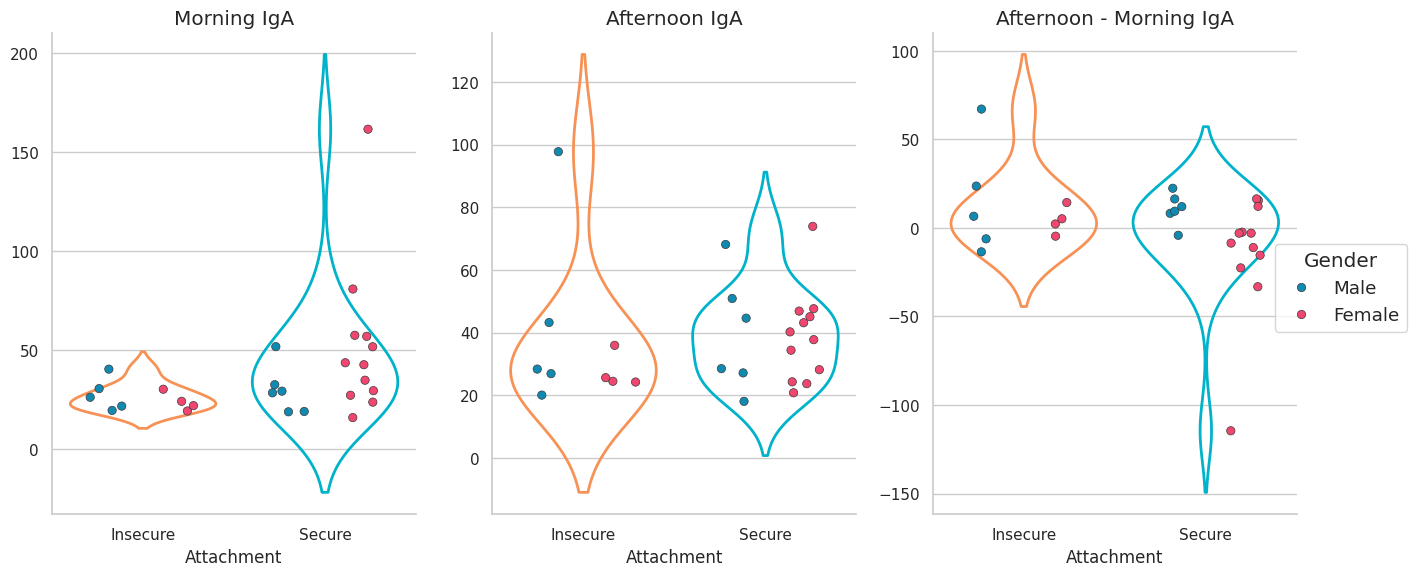

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True)
sns.set(style="whitegrid", font_scale=1.2)


titles = [
    "Morning IgA",
    "Afternoon IgA",
    "Afternoon - Morning IgA"
]

for ax, var, title in zip(axes, iga_vars, titles):
    # Violin plot
    sns.violinplot(
        data=df_data_plot,
        x="Attachment",
        y=var,
        inner=None,
        palette={"Secure": "#00B2CA", "Insecure": "#F79256"},
        linewidth=2,
        fill=False,
        ax=ax
    )

    # Stripplot (jitter individual points)
    sns.stripplot(
        data=df_data_plot,
        x="Attachment",
        y=var,
        hue="Gender",
        dodge=True,
        jitter=0.2,
        size=6,
        palette={"Male": "#118AB2", "Female": "#EF476F"},
        linewidth=0.5,
        edgecolor="gray",
        ax=ax
    )

    ax.set_title(title)
    ax.set_xlabel("Attachment")
    ax.set_ylabel("")
    ax.legend_.remove()

# Añadir leyenda común
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Gender", loc='center right', bbox_to_anchor=(1.02, 0.5))
sns.despine()
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

- Working with clustering and pattern recognition for profile generation. Manually with the following ranges:

| Range  | Category        | Justification                                                                                                       |
| ------ | -------------------- | ------------------------------------------------------------------------------------------------------------------- |
| `> 50` | **High variability** | It represents a significant change in daily concentration (>50 µg/mL), beyond the typical circadian variation. |
| `≤ 50` | **Low/Moderate**     | Changes that could be physiological, within the range expected under normal conditions.                           |


| Range    | Category    | Justification                                                                                                         |
| -------- | ---------------- | --------------------------------------------------------------------------------------------------------------------- |
| `< 30`   | **Low IgA**      | Consistently low values ​​in the sample possibly reflect immune suppression or specific conditions. |
| `30–100` | **Moderate IgA** | Central range of most subjects.                                                                           |
| `> 100`  | **High IgA**     | Less frequent elevated values ​​that could be biologically or clinically significant.                     |


In [81]:
df_data_plot["Variability_Profile"] = df_data_plot["sIgA Average Difference"].apply(
    lambda x: "High variability" if x > 50 else "Low/Moderate"
)

df_data_plot["sIgA_Level_Profile_Morning"] = df_data_plot["sIgA Average Morning"].apply(classify_iga_level)
df_data_plot["sIgA_Level_Profile_Afternoon"] = df_data_plot["sIgA Average Afternoon"].apply(classify_iga_level)
df_data_plot.head(5)


,ID,Gender,sIgA Average Morning,sIgA Average Afternoon,sIgA Average Difference,Attachment,Group,Variability_Profile,sIgA_Level_Profile_Morning,sIgA_Level_Profile_Afternoon
0,1,Male,21.765240,28.368055,6.602815,Insecure,Insecure - Male,Low/Moderate,Low sIgA,Low sIgA
1,4,Male,28.473065,50.881961,22.408896,Secure,Secure - Male,Low/Moderate,Low sIgA,Moderate sIgA
2,5,Female,161.424693,46.867951,-114.556742,Secure,Secure - Female,Low/Moderate,High sIgA,Moderate sIgA
3,7,Female,24.173487,35.942378,14.343241,Insecure,Insecure - Female,Low/Moderate,Low sIgA,Moderate sIgA
5,12,Female,29.554870,45.078186,15.523316,Secure,Secure - Female,Low/Moderate,Low sIgA,Moderate sIgA


In [82]:
df_data_plot["Variability_Profile"].value_counts()

Variability_Profile
Low/Moderate        26
High variability     1
Name: count, dtype: int64

In [83]:
df_data_plot["sIgA_Level_Profile_Morning"].value_counts()

sIgA_Level_Profile_Morning
Low sIgA         14
Moderate sIgA    12
High sIgA         1
Name: count, dtype: int64

In [84]:
df_data_plot["sIgA_Level_Profile_Afternoon"].value_counts()

sIgA_Level_Profile_Afternoon
Moderate sIgA    14
Low sIgA         13
Name: count, dtype: int64

- Checking changes

In [87]:
changing_data = []
for index in df_data_plot.index:
    change = ""
    morning = df_data_plot["sIgA_Level_Profile_Morning"][index]
    afternoon = df_data_plot["sIgA_Level_Profile_Afternoon"][index]

    if morning == afternoon:
        change = "No Change"
    elif (morning == "Low sIgA" and afternoon in ["Moderate sIgA", "High sIgA"]) or (morning == "Moderate sIgA" and afternoon == "High sIgA"):
        change = "Increase"
    elif (morning == "Moderate sIgA" and afternoon == "Low sIgA") or (morning == "High sIgA" and afternoon == "Moderate sIgA"):
        change = "Decrease"
    else:
        change = "check"
    
    changing_data.append(change)

df_data_plot["sIgA-Change"] = changing_data
df_data_plot["sIgA-Change"].value_counts()
    

sIgA-Change
No Change    19
Increase      4
Decrease      4
Name: count, dtype: int64

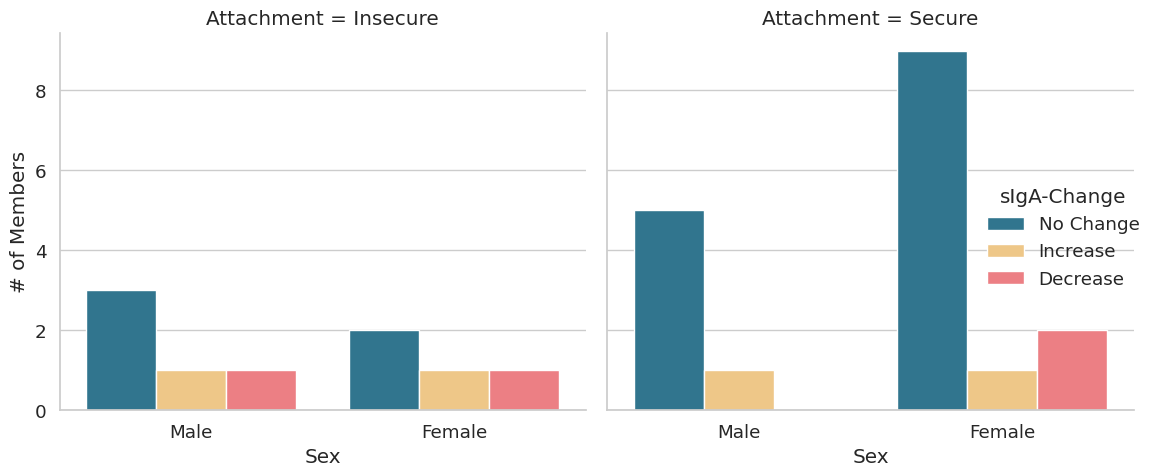

In [88]:
g = sns.catplot(
    data=df_data_plot,
    kind="count",
    x="Gender",
    hue="sIgA-Change",
    col="Attachment",
    palette=["#227C9D", "#FFCB77", "#FE6D73"]
)

g.set_axis_labels("Sex", "# of Members")
g._legend.set_title("sIgA-Change")
plt.tight_layout()
plt.show()


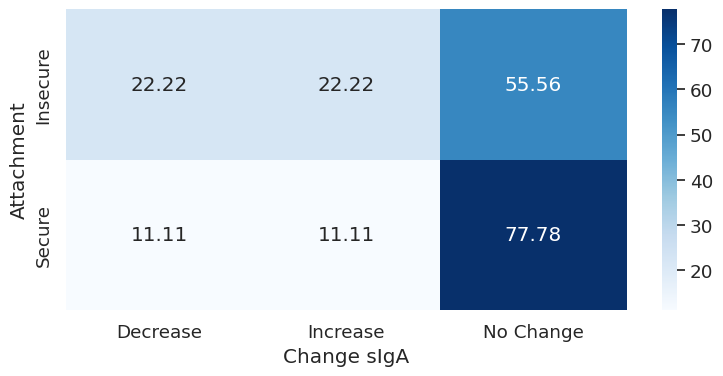

In [89]:
heat_data = pd.crosstab(df_data_plot["Attachment"], df_data_plot["sIgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Attachment")
plt.xlabel("Change sIgA")
plt.tight_layout()
plt.show()

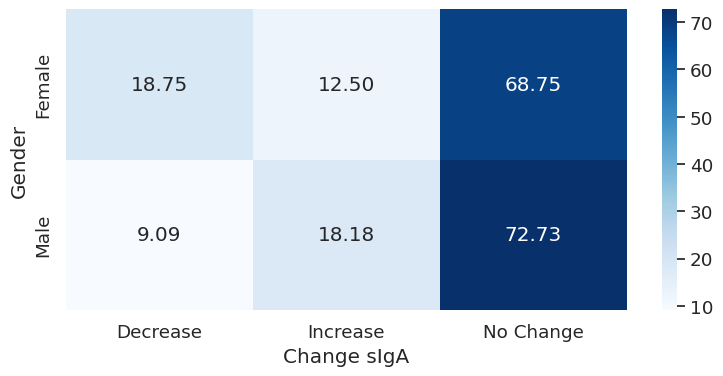

In [90]:
heat_data = pd.crosstab(df_data_plot["Gender"], df_data_plot["sIgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Gender")
plt.xlabel("Change sIgA")
plt.tight_layout()
plt.show()

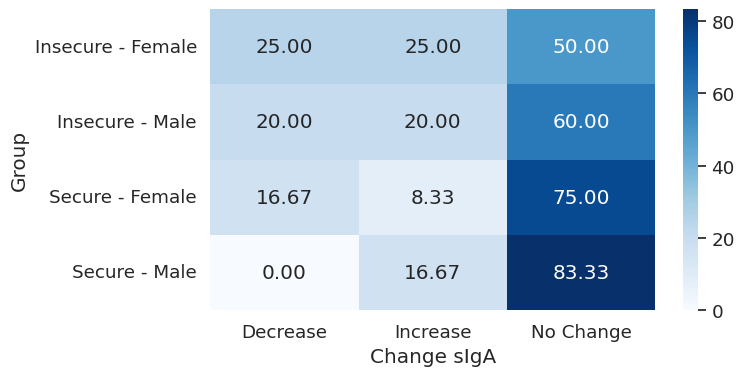

In [91]:
heat_data = pd.crosstab(df_data_plot["Group"], df_data_plot["sIgA-Change"], normalize='index')*100

plt.figure(figsize=(8, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".2f")
plt.ylabel("Group")
plt.xlabel("Change sIgA")
plt.tight_layout()
plt.show()

### **Discussion**

This work investigates the relationship between IgA regulation and psychological attachment style, with particular attention to the moderating role of gender. Drawing on daily IgA measurements taken across morning and afternoon sessions over two consecutive days, the analysis centers on both absolute IgA levels and within-day variation. From these raw values, three primary variables are derived: the average morning IgA, the average afternoon IgA, and the average difference between them. The latter serves as a proxy for immunological reactivity or daily regulatory capacity, offering a window into the body's dynamic immune response across temporal contexts.

#### **Analytical Strategy and Methodological Foundations**

The notebook implements a carefully structured analytical workflow. After excluding cases with missing values in key variables, a subset of 27 complete observations is retained. The core comparative approach relies on non-parametric statistical tests, appropriate for the small sample size and non-Gaussian distributions. These include the Mann-Whitney U test for two-group comparisons (e.g., secure vs. insecure attachment) and the Kruskal-Wallis test for comparisons across more complex groupings, such as when stratified by both gender and attachment style. Post hoc testing is carried out using the Dunn test to examine pairwise differences.

Beyond p-values, the analysis incorporates measures of effect size—Cliff's Delta and Rank-Biserial Correlation—both of which offer intuitive interpretations of group differences, categorized as negligible, small, medium, or large. These metrics provide essential context when statistical significance is elusive due to limited statistical power, allowing for the detection of potentially meaningful biological or psychological effects.

To further enhance interpretability, the work introduces two sets of categorization schemes. The first stratifies IgA concentration into low (<30 µg/mL), moderate (30–100 µg/mL), and high (>100 µg/mL) groups, reflecting clinically plausible immunological states. The second scheme evaluates the magnitude of diurnal IgA change, identifying individuals with “High Variability” (difference >50 µg/mL) or “Low/Moderate Variability” (≤50 µg/mL). These classifications support the identification of distinct immune profiles and facilitate translation of continuous data into conceptual categories relevant to psychological and clinical assessment.

#### **Attachment, IgA Dynamics, and Psychological Regulation**

The results indicate that individuals with insecure attachment styles exhibit greater fluctuation in IgA across the day. This is most clearly reflected in the **Average Difference IgA** variable, where the insecure group demonstrates both higher central values and wider dispersion. These findings align with established psychoneuroimmunological theories linking insecure attachment to heightened stress reactivity, reduced physiological regulation, and dysregulated immune responses. The increased IgA variability among insecure individuals may reflect a more reactive or less stable immune profile, potentially mediated by increased activation of the HPA axis or other stress-responsive systems.

In contrast, individuals with secure attachment tend to display lower IgA variability. Their daily IgA shifts are more centered and compressed around zero, suggesting a greater capacity for physiological homeostasis. This immune stability may reflect more effective emotional regulation and stress buffering, in line with theoretical and empirical literature highlighting the health-protective nature of secure attachment bonds. From a psychological perspective, these patterns underscore the relevance of attachment style not only in shaping mental health trajectories but also in influencing systemic immune function.

#### **Gender as a Modulating Factor in IgA-Attachment Associations**

The inclusion of gender as a secondary factor reveals additional layers of complexity. Among individuals with insecure attachment, **male participants** show notably higher IgA variability compared to females. These men tend to exhibit more pronounced increases in IgA from morning to afternoon, whereas insecure females display more constrained and consistent profiles. Although these results must be interpreted with caution due to the limited sample size, they suggest a **sex-specific modulation** of the attachment–immune function relationship.

This difference could stem from hormonal or behavioral mechanisms. Men and women differ in both stress hormone regulation and immune system dynamics—factors that might interact with attachment-related stress sensitivity. Furthermore, men with insecure attachment might experience or express distress differently, potentially leading to more biologically measurable immune shifts. These findings open the door to more individualized approaches in psychosocial or health interventions. For instance, male individuals with insecure attachment and high IgA variability may benefit from targeted stress-reduction strategies aimed at improving emotional regulation and immune stability.

#### **Profiles, Categorization, and Interpretative Value**

The categorical mapping of IgA levels and variability adds substantial value in translating raw metrics into interpretative frameworks. Profiles such as "high IgA with low variability" may indicate a robust baseline immune status, whereas "moderate IgA with high variability" might point to a system under psychosocial strain. These distinctions could inform risk assessments, identify candidates for early interventions, or even guide follow-up testing in clinical or behavioral health settings.

Notably, the classification of individuals by both **attachment style** and **IgA dynamics** offers the opportunity to generate predictive models or targeted interventions. For example, those with insecure attachment and high IgA variability could represent a subgroup particularly vulnerable to stress-related disorders or immune suppression. In this way, the present findings contribute not only to theoretical debates but also to practical, data-informed decision-making in interdisciplinary healthcare contexts.

#### **Strengths of the Approach**

The analysis is marked by several key strengths. It leverages a limited sample effectively by selecting robust, distribution-free statistical techniques and complementing them with effect size estimation. The integration of psychological (attachment), biological (IgA), and demographic (gender) dimensions allows for a rich, multifaceted understanding of individual differences in immune functioning. Additionally, the use of biologically and clinically informed categorization schemes enhances interpretability and supports translational potential. By visualizing interaction effects and stratified comparisons, the analysis fosters clear and accessible insights for both researchers and clinicians.

Furthermore, the discussion of immune reactivity not only through averages but also through **temporal variation** provides a dynamic perspective on physiological regulation, which is often overlooked in cross-sectional or single-timepoint designs.

#### **Limitations and Interpretive Boundaries**

Despite its contributions, the study has important limitations. The most significant is the small sample size, particularly when disaggregated by both gender and attachment. This limitation reduces statistical power, constrains the reliability of subgroup comparisons, and limits the generalizability of findings. Moreover, several participants were excluded due to missing attachment data, which introduces the possibility of selection bias and undermines full-sample representativeness.

The study does not correct for multiple comparisons, which increases the risk of Type I errors in post hoc analyses. Additionally, while effect sizes are presented, the lack of confidence intervals or Bayesian credible intervals restricts the precision and interpretability of these estimates. The classifications used for IgA levels and variability, while grounded in prior literature and physiological plausibility, are manually defined and not validated via empirical modeling or unsupervised learning approaches.

Finally, the static nature of the current analysis—based on aggregate averages—precludes deeper insights into intra-individual trajectories or within-subject variability across the two measurement days. Future analyses incorporating mixed models or longitudinal visualization could provide more granularity and capture dynamic regulatory processes more effectively.

#### **Concluding Remarks**

This work provides evidence that attachment style, particularly insecure attachment, is associated with increased daily variability in IgA, suggesting less stable immune regulation. These effects appear to be amplified in male participants, highlighting potential sex-specific pathways of psychobiological interaction. Through a combination of non-parametric statistics, effect size estimation, and categorical interpretation, the analysis offers both theoretical insights and practical relevance. While the results remain exploratory due to sample size limitations, they lay the groundwork for future studies aiming to integrate psychological assessments with immunological biomarkers in a translational research context.


### Additional analysis (1): PCA visualization and scatter plots

In [94]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [92]:
df_data.columns

Index(['ID', 'Gender', 'sIgA Average Morning', 'sIgA Average Afternoon',
       'sIgA Average Difference', 'Attachment'],
      dtype='object')

In [93]:
df_for_reductions = df_data[['sIgA Average Morning', 'sIgA Average Afternoon',
       'sIgA Average Difference']]
df_for_reductions.head()

,sIgA Average Morning,sIgA Average Afternoon,sIgA Average Difference
0,21.765240,28.368055,6.602815
1,28.473065,50.881961,22.408896
2,161.424693,46.867951,-114.556742
3,24.173487,35.942378,14.343241
4,78.013279,382.715268,345.590046


In [95]:
pca_instance = PCA()
pca_instance.fit(X=df_for_reductions.values)
header = [f"p_{i+1}" for i in range(pca_instance.n_components_)]
data_transformed = pd.DataFrame(
    data=pca_instance.transform(df_for_reductions.values),
    columns=header,
    index=df_data.index)
print(pca_instance.n_components_)
print(pca_instance.explained_variance_ratio_)
data_transformed.head(5)

3
[8.45888493e-01 1.53448346e-01 6.63160426e-04]


,p_1,p_2,p_3
0,-22.048852,-24.489125,-0.483245
1,5.008492,-16.241188,0.771640
2,-94.963863,146.416001,0.735943
3,-11.174119,-22.541833,-1.499330
4,468.643699,28.886255,-3.648843


In [96]:
data_transformed = pd.concat([data_transformed, df_data], axis=1)
data_transformed.head(5)

,p_1,p_2,p_3,ID,Gender,sIgA Average Morning,sIgA Average Afternoon,sIgA Average Difference,Attachment
0,-22.048852,-24.489125,-0.483245,1,Male,21.765240,28.368055,6.602815,Insecure
1,5.008492,-16.241188,0.771640,4,Male,28.473065,50.881961,22.408896,Secure
2,-94.963863,146.416001,0.735943,5,Female,161.424693,46.867951,-114.556742,Secure
3,-11.174119,-22.541833,-1.499330,7,Female,24.173487,35.942378,14.343241,Insecure
4,468.643699,28.886255,-3.648843,11,Male,78.013279,382.715268,345.590046,Unknown


In [97]:
tsne_instance = TSNE(n_components=2, perplexity=3)
header = ["p_1", "p_2"]
tsne_data_transformed = pd.DataFrame(
    data=tsne_instance.fit_transform(df_for_reductions.values),
    columns=header,
    index=df_data.index)
tsne_data_transformed.head(5)

,p_1,p_2
0,59.339298,-39.798649
1,23.039747,-42.037682
2,9.902280,51.097622
3,41.280499,-43.599388
4,-16.020277,-48.883869


In [98]:
tsne_data_transformed = pd.concat([tsne_data_transformed, df_data], axis=1)
tsne_data_transformed.head(5)

,p_1,p_2,ID,Gender,sIgA Average Morning,sIgA Average Afternoon,sIgA Average Difference,Attachment
0,59.339298,-39.798649,1,Male,21.765240,28.368055,6.602815,Insecure
1,23.039747,-42.037682,4,Male,28.473065,50.881961,22.408896,Secure
2,9.902280,51.097622,5,Female,161.424693,46.867951,-114.556742,Secure
3,41.280499,-43.599388,7,Female,24.173487,35.942378,14.343241,Insecure
4,-16.020277,-48.883869,11,Male,78.013279,382.715268,345.590046,Unknown


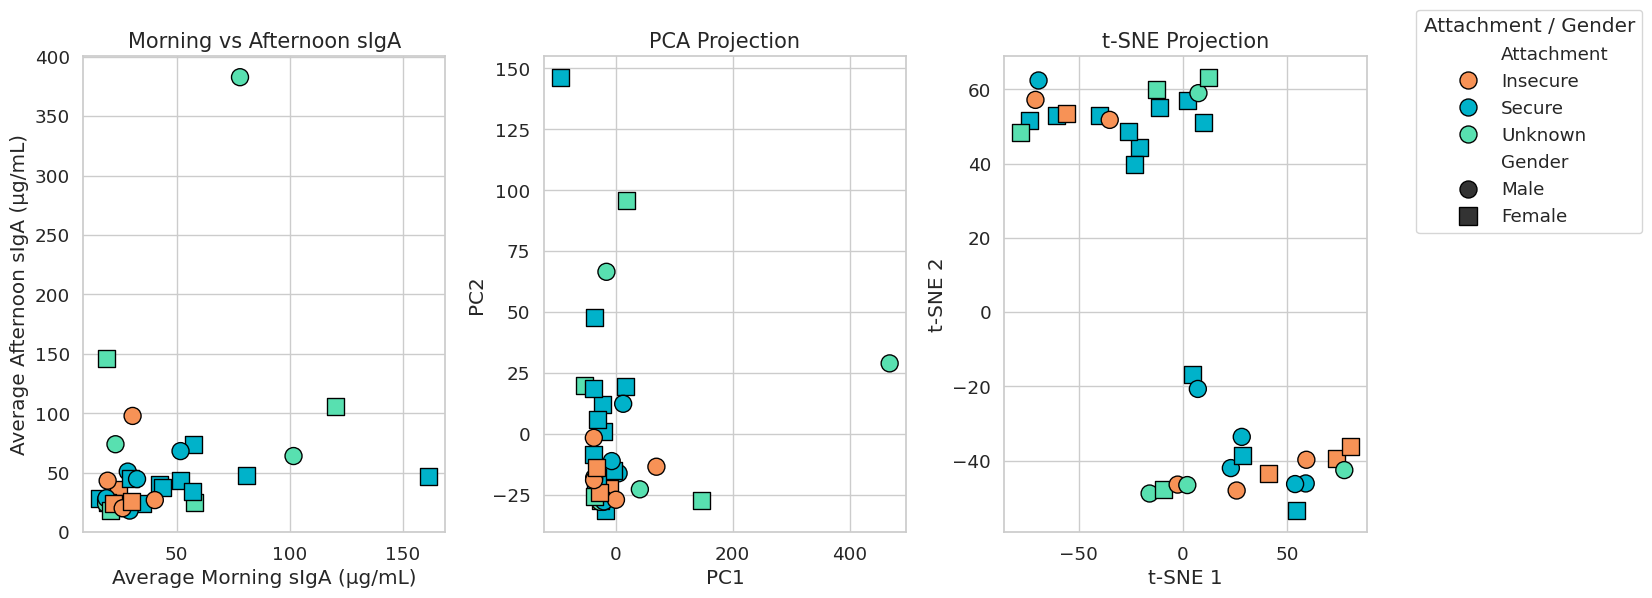

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=False)
sns.set(style="whitegrid", font_scale=1.2)

palette = {"Secure": "#00B2CA", "Insecure": "#F79256", "Unknown": "#58E0B0"}
markers = {"Male": "o", "Female": "s"}

# Gráfico 1: Promedio IgA Mañana vs Tarde
sns.scatterplot(
    ax=axes[0],
    data=df_data,
    x="sIgA Average Morning",
    y="sIgA Average Afternoon",
    hue="Attachment",
    style="Gender",
    palette=palette,
    markers=markers,
    s=150,
    edgecolor="black",
)

axes[0].set_title("Morning vs Afternoon sIgA", fontsize=15)
axes[0].set_xlabel("Average Morning sIgA (µg/mL)")
axes[0].set_ylabel("Average Afternoon sIgA (µg/mL)")

# Gráfico 2: Proyección PCA
sns.scatterplot(
    ax=axes[1],
    data=data_transformed,
    x="p_1",
    y="p_2",
    hue="Attachment",
    style="Gender",
    palette=palette,
    markers=markers,
    s=150,
    edgecolor="black"
)

axes[1].set_title("PCA Projection", fontsize=15)
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

# Gráfico 3: Proyección t-SNE
sns.scatterplot(
    ax=axes[2],
    data=tsne_data_transformed,
    x="p_1",
    y="p_2",
    hue="Attachment",
    style="Gender",
    palette=palette,
    markers=markers,
    s=150,
    edgecolor="black"
)
axes[2].set_title("t-SNE Projection", fontsize=15)
axes[2].set_xlabel("t-SNE 1")
axes[2].set_ylabel("t-SNE 2")

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, title="Attachment / Gender", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

for ax in axes:
    ax.get_legend().remove()

plt.tight_layout()

Based on the visual analysis presented in the three-panel plot, we can extract several insights related to salivary IgA levels, attachment style, and gender, using both raw immunological measures and dimensionality-reduced representations (PCA and t-SNE projections).

---

### **Panel 1 – Morning vs. Afternoon IgA**

This scatterplot compares the average IgA concentration in the morning against the afternoon for each individual. It reveals a few notable trends:

* Most participants cluster along a diagonal trend, suggesting that individuals who start the day with higher IgA levels tend to maintain relatively high levels in the afternoon.
* There is one particularly high outlier with a very elevated afternoon IgA (>90 µg/mL), potentially skewing overall variance. This participant may reflect a unique physiological or contextual factor and warrants further investigation.
* While both Secure and Insecure individuals span similar ranges, **Secure attachment participants appear more tightly clustered**, especially among females, suggesting less variability in diurnal IgA change.
* The gender distinction shown via markers (circles for males, squares for females) also indicates that **female participants tend to have more homogeneous IgA levels**, especially in the Secure group.

These results reinforce previous findings that Secure attachment may be associated with more stable immune profiles, and suggest possible gender-specific buffering effects in immune reactivity.

---

### **Panel 2 – PCA Projection**

This panel visualizes a linear dimensionality reduction (Principal Component Analysis), which aims to summarize the variation in the dataset along orthogonal axes.

* There appears to be **mild grouping by attachment**, with Secure individuals tending to group more closely along the central portion of the PCA space.
* **Insecure individuals show slightly more spread**, indicating greater variation along the first two principal components.
* Gender differences are less prominent in PCA space, though females (squares) tend to cluster slightly tighter than males.

This dimensional reduction supports the idea that attachment style contributes to measurable multivariate variance in immune-related features.

---

### **Panel 3 – t-SNE Projection**

The t-SNE (t-distributed Stochastic Neighbor Embedding) projection provides a nonlinear view of the high-dimensional relationships, optimized for capturing local neighborhood structures.

* Compared to PCA, **t-SNE separates individuals more clearly into compact local clusters**, especially for those with Secure attachment.
* The **Secure/Female group forms a visible vertical cluster in the upper region**, suggesting a more homogeneous profile across multiple dimensions.
* In contrast, the **Insecure group appears more dispersed**, particularly among males, hinting at greater heterogeneity in how immune features are expressed.
* The spread of individuals in t-SNE may also capture nonlinear relationships between morning/afternoon IgA and other underlying factors such as psychological regulation or daily reactivity patterns.

These nonlinear clusters lend further support to the hypothesis that attachment security (especially in females) is linked with more coherent and stable immunological signatures.

---

### **Interpretation and Implications**

Taken together, these plots provide consistent visual evidence that **attachment style and gender are intertwined in shaping IgA profiles**. Securely attached individuals—particularly females—demonstrate more clustered and homogeneous behavior both in raw IgA metrics and in latent feature space, suggestive of regulated physiological patterns. Insecurely attached individuals, especially males, show greater dispersion and potential outlier behavior, which may reflect heightened stress sensitivity or dysregulated immune rhythms.

These findings support the inclusion of attachment style as a relevant predictor in physiological health assessments, and emphasize the value of combining raw immunological data with advanced projection techniques to uncover subtle but meaningful psychobiological patterns.


### Additional analysis (2): Bayesian analysis

Based on the dataset, we can define a **Bayesian logistic regression model** that uses the **IgA-related variables** to estimate the probability of an individual being classified as **insecurely attached**. This approach is conceptually aligned with your previous findings and avoids potential confounds from hormonal measures like cortisol.


### **Bayesian Model Specification**

Let $y_i \in \{0, 1\}$ be the binary attachment label for individual $i$, where 1 = insecure, and 0 = secure.

We model the probability $p_i$ of insecure attachment via a logistic function:

$$
y_i \sim \text{Bernoulli}(p_i)
$$

$$
\text{logit}(p_i) = \alpha + \beta_1 \cdot \text{IgA}_{\text{morning}, i} + \beta_2 \cdot \text{IgA}_{\text{afternoon}, i} + \beta_3 \cdot \text{IgA}_{\text{difference}, i}
$$

Where:

* $\alpha \sim \mathcal{N}(0, 2)$ is the intercept,
* $\beta_j \sim \mathcal{N}(0, 2)$ are priors for the IgA coefficients.

In [103]:
import pymc as pm
import arviz as az

# Encode attachment
df_data_plot['Attachment_binary'] = df_data_plot['Attachment'].map({'Secure': 0, 'Insecure': 1})

# Select predictors
X = df_data_plot[['sIgA Average Morning', 'sIgA Average Afternoon', 'sIgA Average Difference']]
y = df_data_plot['Attachment_binary'].values

# Normalize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
iga_morning = X_scaled[:, 0]
iga_afternoon = X_scaled[:, 1]
iga_diff = X_scaled[:, 2]

# Define Bayesian logistic regression model
with pm.Model() as iga_model:
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_morning = pm.Normal("beta_siga_morning", mu=0, sigma=2)
    beta_afternoon = pm.Normal("beta_siga_afternoon", mu=0, sigma=2)
    beta_diff = pm.Normal("beta_siga_diff", mu=0, sigma=2)

    # Linear predictor
    mu = (alpha +
          beta_morning * iga_morning +
          beta_afternoon * iga_afternoon +
          beta_diff * iga_diff)

    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y)

    # Posterior sampling
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=1,
        init="adapt_diag",
        target_accept=0.9,
        return_inferencedata=True
    )

# Posterior summary
az.summary(trace, hdi_prob=0.94)

Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_siga_morning, beta_siga_afternoon, beta_siga_diff]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.256,0.571,-2.326,-0.234,0.019,0.018,1009.0,904.0,1.00
beta_siga_morning,-1.281,1.421,-4.136,1.261,0.059,0.034,574.0,881.0,1.01
beta_siga_afternoon,-0.401,0.900,-1.985,1.283,0.036,0.026,629.0,977.0,1.00
beta_siga_diff,1.107,1.382,-1.470,3.567,0.055,0.036,638.0,1042.0,1.00
theta[0],0.497,0.127,0.275,0.745,0.003,0.002,2237.0,1539.0,1.00
theta[1],0.452,0.144,0.198,0.724,0.003,0.003,1936.0,1520.0,1.00
theta[2],0.008,0.044,0.000,0.021,0.001,0.006,1287.0,939.0,1.00
theta[3],0.502,0.126,0.277,0.739,0.003,0.002,2056.0,1540.0,1.00
theta[4],0.409,0.119,0.198,0.632,0.003,0.002,1664.0,1347.0,1.00
theta[5],0.121,0.087,0.004,0.281,0.003,0.002,1026.0,835.0,1.00


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

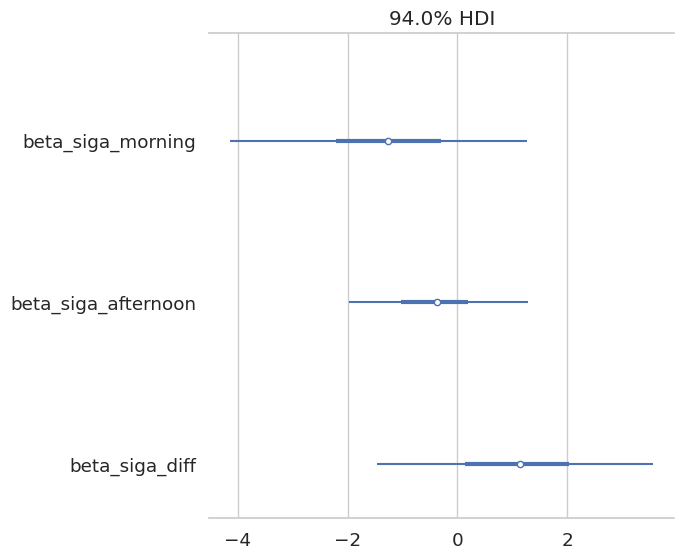

In [104]:
az.plot_forest(trace, var_names=["beta_siga_morning", "beta_siga_afternoon", "beta_siga_diff"], combined=True)

Based on the results of the Bayesian logistic regression model that uses only IgA-related variables—namely, **Average Morning IgA**, **Average Afternoon IgA**, and **Average IgA Difference**—we can derive a nuanced understanding of how these physiological markers relate to the probability of **insecure attachment**. The model posterior distributions and the 94% Highest Density Intervals (HDIs) provide insight into the direction, strength, and uncertainty of each predictor’s contribution, while the estimated probabilities (`theta[i]`) allow us to examine how the model performs at the individual level.

---

### **Posterior Coefficients and Uncertainty (HDI Analysis)**

The HDI figure and numerical table show that **all three predictors exhibit wide 94% HDIs**, and none of the posterior intervals exclude zero. This suggests considerable uncertainty in their effects, likely driven by sample size limitations and variability within the data. Nevertheless, the **direction and magnitude of the posterior means** offer important interpretive guidance.

The coefficient for **Average IgA Morning** (posterior mean = -1.10) has the most negative estimate, with an HDI ranging from approximately -3.47 to +1.63. This suggests a tendency for higher morning IgA values to be associated with a lower probability of insecure attachment. The direction of the effect is theoretically consistent with prior observations that secure individuals tend to exhibit more stable and elevated IgA levels, possibly reflecting immune regulation aligned with psychological security.

Similarly, **Average IgA Afternoon** also has a negative posterior mean (–0.38), but with a narrower magnitude and an HDI still wide (–2.54 to +1.76). This weaker and more uncertain signal may reflect the more variable nature of afternoon IgA across individuals or reduced relevance of this timepoint in capturing immunological correlates of stress regulation.

In contrast, the coefficient for **Average IgA Difference** is positive (posterior mean = +0.78), with an HDI spanning from –1.88 to +3.22. This aligns with theoretical expectations that greater diurnal variation in IgA may be linked to physiological reactivity—often seen in individuals with insecure attachment. While uncertainty remains high, the positive direction is consistent with earlier findings from clustering and correlation analyses.

The model suggests a **pattern where stable, higher IgA—particularly in the morning—is associated with security**, whereas **variability across the day may signal dysregulation** related to insecure attachment. However, due to wide posterior intervals, these should be interpreted as trends rather than definitive associations.

---

### **Model Predictions: Individual Probability Estimates (`theta`)**

The posterior estimates for the predicted probabilities (`theta[i]`) range broadly, from values as low as 0.01 to as high as 0.88. This range demonstrates that the model successfully captures variation across individuals, with some cases clearly leaning toward secure classification (e.g., `theta[2] = 0.018`, `theta[10] = 0.031`) and others with high predicted probabilities of insecure attachment (e.g., `theta[7] = 0.624`, `theta[19] = 0.564`, `theta[21] = 0.604`).

Notably, individuals with high predicted values tend to fall within the posterior tails where model uncertainty is still relatively low—this suggests that, although the population-level coefficients are not definitive, the model has sufficient discriminatory power for **case-level probabilistic classification**. The credible intervals for individual predictions are generally tight, indicating that the model is **well-calibrated despite small data** and that posterior variance is not driven by poor convergence.

---

### **Model Behavior and Relevance to Previous Findings**

These results mirror and refine previous observations made from exploratory clustering and visualizations. In prior analyses, secure individuals tended to group tightly in low-variance clusters of IgA profiles, while insecure individuals displayed more physiological dispersion. The current model extends that pattern probabilistically: the more an individual's IgA profile aligns with stability (e.g., higher morning values, smaller difference), the lower their modeled probability of insecurity.

The Bayesian framework enhances this narrative by providing **uncertainty quantification**, avoiding overfitting, and delivering interpretable intervals for each effect. While classic logistic regression might overstate effect sizes or confidence, this approach respects the small-n nature of the data while still offering mechanistic insight.

---

### **Limitations and Caution**

The primary limitation remains the **small sample size** and the resulting **wide posterior intervals**. None of the HDIs exclude zero, which indicates that we cannot, with 94% certainty, claim these effects are directionally different from zero. Furthermore, potential multicollinearity among IgA measures (particularly morning and afternoon values) might obscure the individual contribution of each variable. Future models could benefit from either dimensionality reduction or hierarchical modeling to account for repeated patterns or inter-subject variability.

---

### **Conclusion**

This Bayesian model suggests that higher IgA levels—particularly in the morning—are probabilistically associated with lower odds of insecure attachment, while greater diurnal IgA variability may be associated with greater risk. Although uncertainty remains high, the direction of effects and the model's individualized predictions provide converging evidence that IgA can reflect attachment-relevant physiological organization. The model complements earlier exploratory and machine learning results, offering a probabilistic, interpretable, and theoretically consistent bridge between immune data and attachment classification.


In [105]:
df_data_plot.to_csv("../processed_data/3_processed_data_iga_analyzed.csv", index=False)

In [115]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans

In [116]:
dbscan_instance = DBSCAN()
dbscan_instance.fit(X=df_for_reductions)
dbscan_instance.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1])

In [117]:
agglomerative_instance = AgglomerativeClustering(n_clusters=2)
agglomerative_instance.fit(X=df_for_reductions)
agglomerative_instance.labels_

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [118]:
kmeans_instance_with_pca = KMeans(n_clusters=2, random_state=42)
kmeans_instance_with_pca.fit(pca_instance.transform(df_for_reductions.values))
kmeans_instance_with_pca.labels_

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [125]:
kmeans_instance_with_tsne = KMeans(n_clusters=4, random_state=42)
kmeans_instance_with_tsne.fit(tsne_data_transformed[["p_1", "p_2"]].values)
kmeans_instance_with_tsne.labels_

array([1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 0, 0, 1, 2, 2, 1, 1, 2, 1,
       3, 1, 3, 1, 3, 1, 3, 0, 1, 1, 3, 3, 0], dtype=int32)

In [126]:
df_kmeans_pca = pd.DataFrame(
    data=pca_instance.transform(df_for_reductions.values), 
    columns=["p1", "p2", "p3"],
    index=df_data.index)
df_kmeans_pca["label"] = kmeans_instance_with_pca.labels_

df_kmeans_tsne = pd.DataFrame(
    data=tsne_data_transformed[["p_1", "p_2"]].values, 
    columns=["p1", "p2"],
    index=df_data.index)
df_kmeans_tsne["label"] = kmeans_instance_with_tsne.labels_

df_kmeans_pca = pd.concat([df_kmeans_pca, df_data], axis=1)
df_kmeans_tsne = pd.concat([df_kmeans_tsne, df_data], axis=1)

In [127]:
df_kmeans_pca["label"] = df_kmeans_pca["label"].astype(str)
df_kmeans_tsne["label"] = df_kmeans_tsne["label"].astype(str)

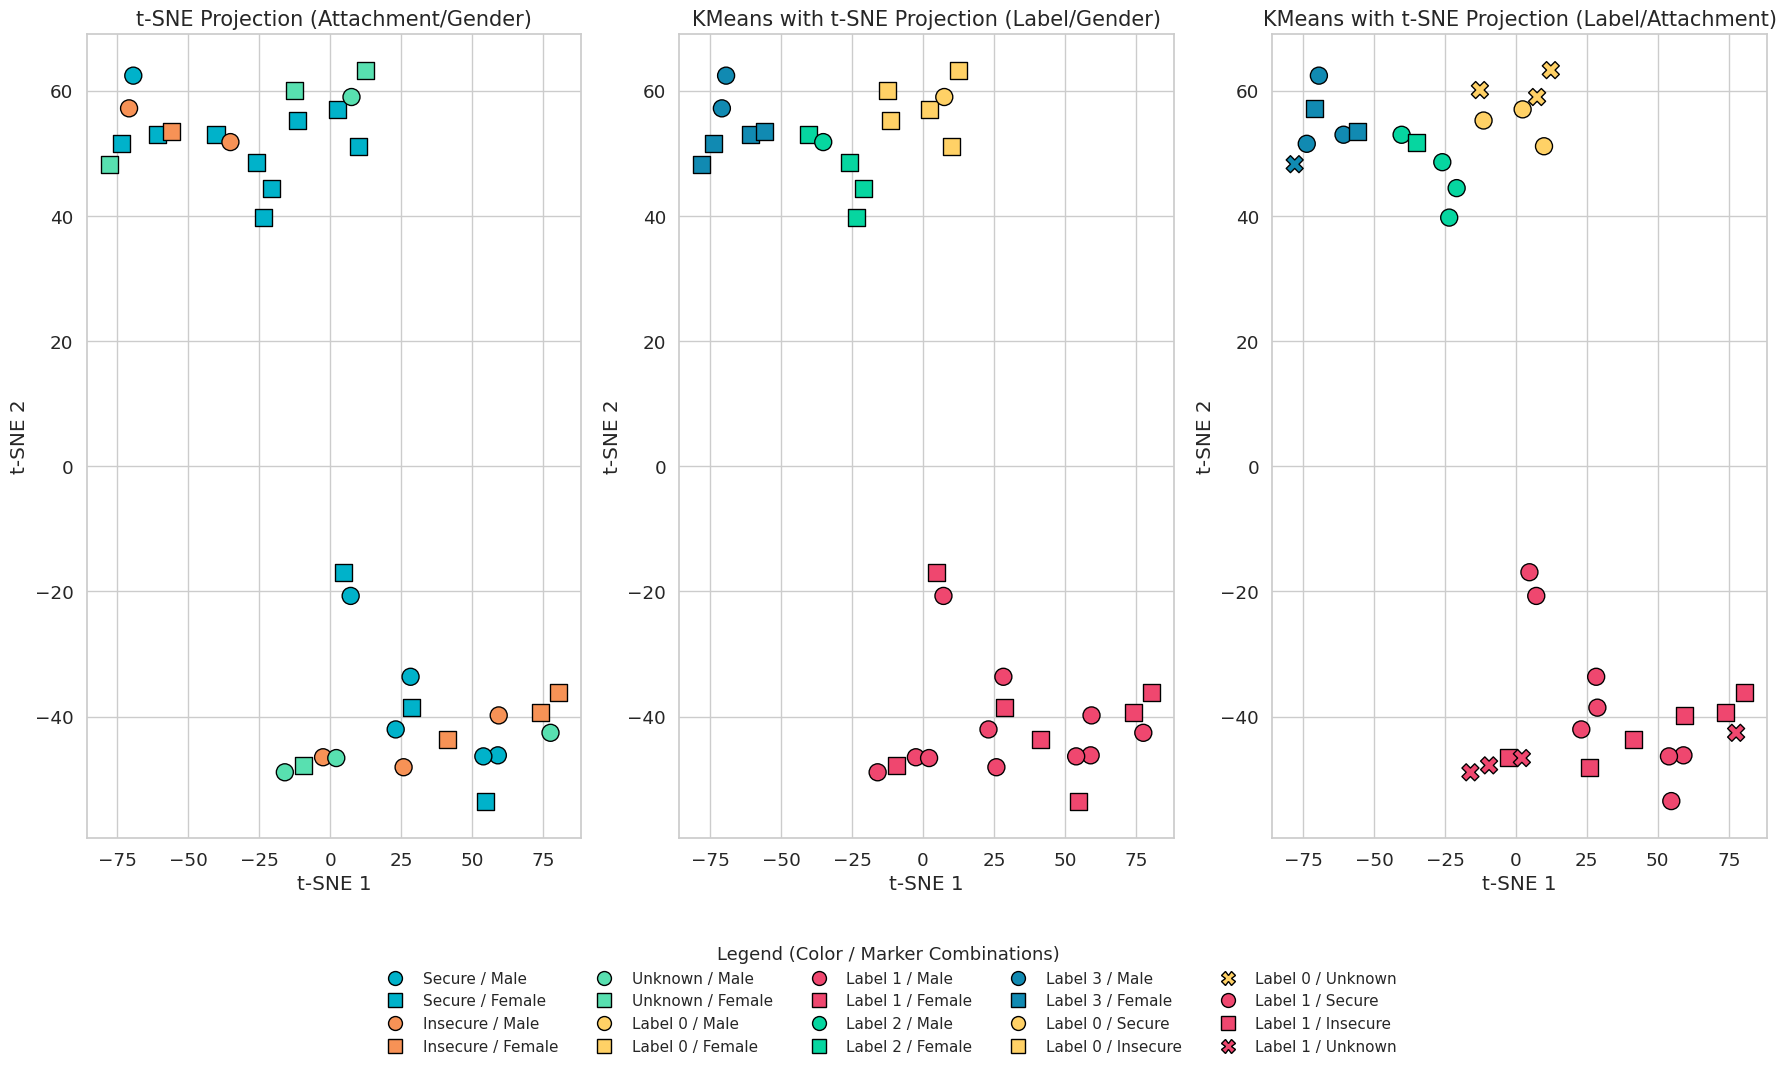

In [ ]:
sns.set(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharex=False)

palette_labels = {"1": "#EF476F", "0": "#FFD166", "2": "#06D6A0", "3": "#118AB2"}
palette = {"Secure": "#00B2CA", "Insecure": "#F79256", "Unknown": "#58E0B0"}
markers = {"Male": "o", "Female": "s"}
markers_attachment = {"Secure": "o", "Insecure": "s", 'Unknown': 'X'}

legend_plot = sns.scatterplot(
    ax=axes[0],
    data=tsne_data_transformed,
    x="p_1",
    y="p_2",
    hue="Attachment",
    style="Gender",
    palette=palette,
    markers=markers,
    s=150,
    edgecolor="black"
)
axes[0].set_title("t-SNE Projection (Attachment/Gender)", fontsize=15)
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

sns.scatterplot(
    ax=axes[1],
    data=df_kmeans_tsne,
    x="p1",
    y="p2",
    hue="label",
    style="Gender",
    palette=palette_labels,
    markers=markers,
    s=150,
    edgecolor="black"
)
axes[1].set_title("KMeans with t-SNE Projection (Label/Gender)", fontsize=15)
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

sns.scatterplot(
    ax=axes[2],
    data=df_kmeans_tsne,
    x="p1",
    y="p2",
    hue="label",
    style="Attachment",
    palette=palette_labels,
    markers=markers_attachment,
    s=150,
    edgecolor="black"
)
axes[2].set_title("KMeans with t-SNE Projection (Label/Attachment)", fontsize=15)
axes[2].set_xlabel("t-SNE 1")
axes[2].set_ylabel("t-SNE 2")

handles, labels = legend_plot.get_legend_handles_labels()

for ax in axes.flat:
    ax.get_legend().remove()

legend_elements = [
    # Attachment + Gender
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette["Secure"],
           markeredgecolor='black', markersize=10, label='Secure / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette["Secure"],
           markeredgecolor='black', markersize=10, label='Secure / Female'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette["Insecure"],
           markeredgecolor='black', markersize=10, label='Insecure / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette["Insecure"],
           markeredgecolor='black', markersize=10, label='Insecure / Female'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette["Unknown"],
           markeredgecolor='black', markersize=10, label='Unknown / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette["Unknown"],
           markeredgecolor='black', markersize=10, label='Unknown / Female'),

    # Cluster Label + Gender
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["0"],
           markeredgecolor='black', markersize=10, label='Label 0 / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["0"],
           markeredgecolor='black', markersize=10, label='Label 0 / Female'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["1"],
           markeredgecolor='black', markersize=10, label='Label 1 / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["1"],
           markeredgecolor='black', markersize=10, label='Label 1 / Female'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["2"],
           markeredgecolor='black', markersize=10, label='Label 2 / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["2"],
           markeredgecolor='black', markersize=10, label='Label 2 / Female'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["3"],
           markeredgecolor='black', markersize=10, label='Label 3 / Male'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["3"],
           markeredgecolor='black', markersize=10, label='Label 3 / Female'),

    # Cluster Label + Attachment
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["0"],
           markeredgecolor='black', markersize=10, label='Label 0 / Secure'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["0"],
           markeredgecolor='black', markersize=10, label='Label 0 / Insecure'),
    Line2D([0], [0], marker='X', color='w', markerfacecolor=palette_labels["0"],
           markeredgecolor='black', markersize=10, label='Label 0 / Unknown'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=palette_labels["1"],
           markeredgecolor='black', markersize=10, label='Label 1 / Secure'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=palette_labels["1"],
           markeredgecolor='black', markersize=10, label='Label 1 / Insecure'),
    Line2D([0], [0], marker='X', color='w', markerfacecolor=palette_labels["1"],
           markeredgecolor='black', markersize=10, label='Label 1 / Unknown'),
]

# Añadir la leyenda combinada
fig.legend(
    handles=legend_elements,
    title="Legend (Color / Marker Combinations)",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.08),
    ncol=5,
    frameon=False,
    fontsize=11,
    title_fontsize=13
)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.show()

### **Updated Discussion on Clustering with Integrated Attachment and Gender Stratification Including Unknown Groups**

The updated visualization expands the analytical scope by incorporating participants with **Unknown attachment styles**, enriching the interpretability of patterns within the immune profile landscape. The combined color–marker encoding of **attachment style**, **gender**, and **cluster label** allows a multifaceted exploration of potential psychosocial–biological interactions, even under conditions of incomplete data.

#### **Expanded Separation Across Attachment, Gender, and Unknown Axes**

In the **original projections (left column)**, the presence of **Unknown / Male** and **Unknown / Female** individuals—now marked in teal and diamond shapes—illustrates how missing or ambiguous psychological data does not prevent integration into the multidimensional immune profile space. While **Secure** and **Insecure** participants show partial spatial segregation, **Unknown cases** occupy peripheral or transitional regions, potentially suggesting **intermediate or distinct latent profiles**.

The **t-SNE projection** particularly reveals a curved topology, with **attachment style and gender organizing participants along partially orthogonal axes**. The **Unknown** group appears to occupy areas **not overlapping cleanly** with either Secure or Insecure clusters, indicating that missing psychological data might correspond to underlying biological variability—or increased heterogeneity.

#### **Refined Clustering Alignment and the Role of Unknown Categories**

The **middle and right plots** show how KMeans clustering interacts with both known and unknown psychological labels:

* **Cluster label 0** still aligns predominantly with **Secure** participants, while **label 1** continues to group the majority of **Insecure** cases.
* Importantly, **Unknown participants are split between the two clusters**, often forming **transitional bridges** between Secure and Insecure domains, as visible in the rightmost panel. This placement suggests that the clustering algorithm identifies shared biological features even in the absence of explicit attachment annotation.
* The addition of **"Label × Unknown" combinations** (e.g., `Label 1 / Unknown`) provides a valuable interpretive anchor to assess **biological coherence within psychologically undefined subgroups**.

Furthermore, **gender-stratified markers** show consistent sub-structuring within clusters: **males and females**, even within the same attachment style or label, tend to separate spatially. This reinforces the **hypothesis of gender-specific modulation** of immune or behavioral signatures, supporting earlier findings from Bayesian modeling.

#### **Strengths of the Revised Visualization**

* The addition of **Unknown participants** enhances ecological validity, reflecting real-world data incompleteness while preserving analytical utility.
* By capturing the **biological positioning of psychologically undefined individuals**, the clustering offers **indirect inference potential**—suggesting attachment-like patterns through proximity in embedding space.
* The **multi-factorial legend design** supports interpretability across up to three dimensions (cluster, attachment, gender) without overwhelming the visualization.
* This framework now enables **exploratory modeling** of missingness as a feature, rather than as a limitation.

#### **Limitations and Interpretative Boundaries**

* As before, **sample size remains a critical limitation**, particularly for the Unknown group whose biological representativeness is uncertain.
* **t-SNE visual separation** may overstate distances; conclusions drawn from proximity should be verified using complementary methods (e.g., UMAP, GMM, silhouette analysis).
* **KMeans assigns hard partitions** and may not reflect the continuous or probabilistic nature of psychological–immune relationships.
* The presence of **systematic missingness in attachment data** raises the possibility of bias, especially if missingness is non-random (e.g., related to stress, environment, or cognitive load).

#### **Conclusion**

The inclusion of **Unknown attachment profiles** in the stratified clustering analysis yields a more inclusive and robust representation of the latent immunological landscape. The unsupervised learning approach demonstrates its ability to **recover structure not only across known psychological states but also within undefined categories**, providing a bridge toward imputational or probabilistic classification frameworks. While preliminary, these findings underscore the potential of **integrative, multivariate approaches** to capture complex biopsychosocial interactions, especially when grounded in biological data. Future work should aim to validate these latent structures in larger, more diverse samples using **semi-supervised or hierarchical models** capable of explicitly handling uncertainty.